In [1]:
import os
# Add directory for NVIDIA gpu. Ignore if not Windows
os.add_dll_directory("C:/Program Files/NVIDIA GPU Computing Toolkit/CUDA/v11.2/bin")

<AddedDllDirectory('C:/Program Files/NVIDIA GPU Computing Toolkit/CUDA/v11.2/bin')>

In [2]:
import tensorflow as tf
# print(tf.reduce_sum(tf.random.normal([1000, 1000])))
# Confirm tensorflow running on gpu
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
from tensorflow import keras
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import Resizing
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle as pkl

### Base CovNet Model

In [4]:
# function to build the conv net base


# complete this function
def build_base_convnet_model():
    """Re-create the model from the first prompt, but with a different input shape"""
    
    # Return this variable
    model = None
    
    # YOUR CODE HERE
    inputs = keras.Input(shape = (299, 299, 3))
    x = keras.layers.Conv2D(filters = 32, kernel_size = 3, activation = 'relu')(inputs)
    x = keras.layers.MaxPooling2D(pool_size = 2)(x)
    x = keras.layers.Conv2D(filters = 64, kernel_size = 3, activation = 'relu')(x)
    x = keras.layers.MaxPooling2D(pool_size = 2)(x)
    x = keras.layers.Conv2D(filters = 128, kernel_size = 3, activation = 'relu')(x)
    x = keras.layers.Flatten()(x)
    outputs = keras.layers.Dense(1, activation = 'sigmoid')(x)

    model = keras.Model(inputs, outputs)

    model.compile(loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    return model

def load_image_data(base_path: str) -> tuple:
    """Write a function that accepts a base path that contains all of the directories, and creates training,
    validation and test sets"""
    
    # Return these variables from the function
    train_data = keras.utils.image_dataset_from_directory(f'{base_path}/train', 
                                                          image_size = (299, 299),
                                                          batch_size = 64)

    validation_data = keras.utils.image_dataset_from_directory(f'{base_path}/val', 
                                                          image_size = (299, 299),
                                                          batch_size = 64)
    
    test_data = keras.utils.image_dataset_from_directory(f'{base_path}/test', 
                                                          image_size = (299, 299),
                                                          batch_size = 64)
    
    # YOUR CODE HERE
    
    
    return train_data, validation_data, test_data

def fit_model(model, train_set, validation_set):
    """Fit a model with the above stated criteria"""
    early_stopping = keras.callbacks.EarlyStopping(patience = 10)
    
    # YOUR CODE HERE
    model.fit(train_set, 
              validation_data = validation_set, 
              callbacks = [early_stopping], 
              epochs = 500)
    
    return model

In [5]:
# run this cell to create your base convolution model and training, validation & test sets
base_mod = build_base_convnet_model()
train_data, validation_data, test_data = load_image_data('../data/COVID-19_Radiography_Dataset/TwoClasses/split')

Found 8284 files belonging to 2 classes.
Found 2761 files belonging to 2 classes.
Found 2763 files belonging to 2 classes.


In [6]:
fitted_model = fit_model(base_mod, train_data, validation_data)

Epoch 1/500
130/130 [==============================] - 66s 449ms/step - loss: 67.5490 - accuracy: 0.7403 - val_loss: 0.3755 - val_accuracy: 0.8356
Epoch 2/500
130/130 [==============================] - 20s 155ms/step - loss: 24.8731 - accuracy: 0.7859 - val_loss: 3.1400 - val_accuracy: 0.7841
Epoch 3/500
130/130 [==============================] - 20s 152ms/step - loss: 3.9616 - accuracy: 0.8419 - val_loss: 0.4280 - val_accuracy: 0.8526
Epoch 4/500
130/130 [==============================] - 22s 169ms/step - loss: 26.9102 - accuracy: 0.8416 - val_loss: 2.7879 - val_accuracy: 0.8700
Epoch 5/500
130/130 [==============================] - 20s 152ms/step - loss: 2.7133 - accuracy: 0.8842 - val_loss: 0.6322 - val_accuracy: 0.8627
Epoch 6/500
130/130 [==============================] - 20s 150ms/step - loss: 3.0722 - accuracy: 0.9019 - val_loss: 0.3973 - val_accuracy: 0.8939
Epoch 7/500
130/130 [==============================] - 21s 159ms/step - loss: 2.6714 - accuracy: 0.9056 - val_loss: 1.413

In [7]:
# Create test labels from image_dataset
test_labels = np.concatenate([y for x, y in test_data], axis=0)

# Flatten function needed to flatten nested lists from predictions
def flatten(l):
    return [item for sublist in l for item in sublist]

# Some predictions are not correctly labeled as 1,0
predictions = np.where(fitted_model.predict(test_data) > 0.5, 1, 0)
predictions

y_preds = flatten(predictions)

cm = confusion_matrix(test_labels, y_preds)
cm

44/44 [==============================] - 3s 70ms/step


array([[ 189,  535],
       [ 512, 1527]], dtype=int64)

In [8]:
target_names = ['Covid (Class 0)', 'Normal (Class 1)']
print(classification_report(test_labels, y_preds, target_names = target_names))

                  precision    recall  f1-score   support

 Covid (Class 0)       0.27      0.26      0.27       724
Normal (Class 1)       0.74      0.75      0.74      2039

        accuracy                           0.62      2763
       macro avg       0.51      0.50      0.50      2763
    weighted avg       0.62      0.62      0.62      2763



### Inception V3 Model



In [9]:
from keras.applications import InceptionV3

In [10]:
def build_transfer_learning_model():
    
    # return this variable
    model = None

    model_input = keras.Input(shape = (299, 299, 3))
    
    base_model = InceptionV3(input_shape = (299, 299, 3), weights='imagenet', include_top=False)

    # make the weights in the base model non-trainable
    for layer in base_model.layers:
      layer.trainable = False

    # combine the base model with a dense layer and output layer for the 10 classes
    # the preprocess_input transforms input data according to how the model was trained
    
    x = keras.applications.inception_v3.preprocess_input(model_input)
    x = base_model(x)
    x = keras.layers.Flatten()(x)
    x = keras.layers.Dense(256, activation = 'relu')(x)
    x = keras.layers.Dropout(0.5)(x)
    output = keras.layers.Dense(1, activation = 'sigmoid')(x)

    model = keras.Model(model_input, output)

    model.compile(loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    return model

In [11]:
transfer_learning_mod = build_transfer_learning_model()

In [12]:
inception_model = fit_model(transfer_learning_mod, train_data, validation_data)

Epoch 1/500
130/130 [==============================] - 31s 208ms/step - loss: 5.9614 - accuracy: 0.8166 - val_loss: 0.2429 - val_accuracy: 0.9218
Epoch 2/500
130/130 [==============================] - 25s 193ms/step - loss: 0.4760 - accuracy: 0.8859 - val_loss: 0.8134 - val_accuracy: 0.8196
Epoch 3/500
130/130 [==============================] - 25s 193ms/step - loss: 0.3964 - accuracy: 0.9069 - val_loss: 0.1400 - val_accuracy: 0.9522
Epoch 4/500
130/130 [==============================] - 25s 189ms/step - loss: 0.2737 - accuracy: 0.9314 - val_loss: 0.1448 - val_accuracy: 0.9511
Epoch 5/500
130/130 [==============================] - 26s 197ms/step - loss: 0.2157 - accuracy: 0.9394 - val_loss: 0.1240 - val_accuracy: 0.9598
Epoch 6/500
130/130 [==============================] - 26s 195ms/step - loss: 0.1798 - accuracy: 0.9497 - val_loss: 0.1472 - val_accuracy: 0.9602
Epoch 7/500
130/130 [==============================] - 25s 195ms/step - loss: 0.1961 - accuracy: 0.9505 - val_loss: 0.1655 -

In [13]:
inc_results = inception_model.evaluate(test_data)

44/44 [==============================] - 6s 139ms/step - loss: 0.1545 - accuracy: 0.9678


44/44 [==============================] - 3s 69ms/step


<AxesSubplot: >

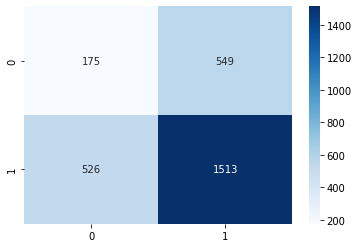

In [14]:
# Create test labels from image_dataset
test_labels = np.concatenate([y for x, y in test_data], axis=0)

# Flatten function needed to flatten nested lists from predictions
def flatten(l):
    return [item for sublist in l for item in sublist]

# Some predictions are not correctly labeled as 1,0
predictions = np.where(fitted_model.predict(test_data) > 0.5, 1, 0)
predictions

y_preds = flatten(predictions)

cm = confusion_matrix(test_labels, y_preds)
sns.heatmap(cm, annot = True, cmap='Blues', fmt='.4g')

In [15]:
target_names = ['Covid (Class 0)', 'Normal (Class 1)']
print(classification_report(test_labels, y_preds, target_names = target_names))

                  precision    recall  f1-score   support

 Covid (Class 0)       0.25      0.24      0.25       724
Normal (Class 1)       0.73      0.74      0.74      2039

        accuracy                           0.61      2763
       macro avg       0.49      0.49      0.49      2763
    weighted avg       0.61      0.61      0.61      2763



### ResNet Model

In [16]:
from keras.applications import ResNet50

In [17]:
def build_transfer_learning_model():
    
    # return this variable
    model = None

    model_input = keras.Input(shape = (299, 299, 3))
    
    base_model = ResNet50(input_shape = (299, 299, 3), weights='imagenet', include_top=False)

    # make the weights in the base model non-trainable
    for layer in base_model.layers:
      layer.trainable = False

    # combine the base model with a dense layer and output layer for the 10 classes
    # the preprocess_input transforms input data according to how the model was trained
    
    x = keras.applications.resnet50.preprocess_input(model_input)
    x = base_model(x)
    x = keras.layers.Flatten()(x)
    x = keras.layers.Dense(256, activation = 'relu')(x)
    x = keras.layers.Dropout(0.5)(x)
    output = keras.layers.Dense(1, activation = 'sigmoid')(x)

    model = keras.Model(model_input, output)

    model.compile(loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    return model

In [18]:
transfer_learning_mod = build_transfer_learning_model()

In [19]:
resnet_model = fit_model(transfer_learning_mod, train_data, validation_data)

Epoch 1/500
130/130 [==============================] - 29s 202ms/step - loss: 5.3746 - accuracy: 0.8904 - val_loss: 0.9255 - val_accuracy: 0.8989
Epoch 2/500
130/130 [==============================] - 25s 195ms/step - loss: 0.5181 - accuracy: 0.9357 - val_loss: 0.2654 - val_accuracy: 0.9276
Epoch 3/500
130/130 [==============================] - 25s 194ms/step - loss: 0.2972 - accuracy: 0.9536 - val_loss: 0.0997 - val_accuracy: 0.9739
Epoch 4/500
130/130 [==============================] - 26s 199ms/step - loss: 0.3004 - accuracy: 0.9617 - val_loss: 0.1871 - val_accuracy: 0.9750
Epoch 5/500
130/130 [==============================] - 25s 189ms/step - loss: 0.1564 - accuracy: 0.9714 - val_loss: 0.6624 - val_accuracy: 0.9457
Epoch 6/500
130/130 [==============================] - 24s 186ms/step - loss: 0.1222 - accuracy: 0.9785 - val_loss: 0.1375 - val_accuracy: 0.9826
Epoch 7/500
130/130 [==============================] - 24s 186ms/step - loss: 0.0932 - accuracy: 0.9819 - val_loss: 0.1303 -

In [20]:
results = resnet_model.evaluate(test_data)

44/44 [==============================] - 6s 130ms/step - loss: 0.1733 - accuracy: 0.9772


44/44 [==============================] - 6s 127ms/step


<AxesSubplot: >

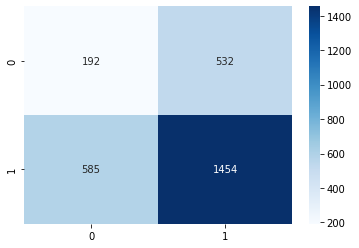

In [21]:
# Some predictions are continuous and thus not labeled as 1,0
predictions = np.where(resnet_model.predict(test_data) > 0.5, 1, 0)
predictions

y_preds = flatten(predictions)

cm = confusion_matrix(test_labels, y_preds)
sns.heatmap(cm, annot = True, cmap='Blues', fmt='.4g')

In [22]:
target_names = ['Covid (Class 0)', 'Normal (Class 1)']
print(classification_report(test_labels, y_preds, target_names = target_names))

                  precision    recall  f1-score   support

 Covid (Class 0)       0.25      0.27      0.26       724
Normal (Class 1)       0.73      0.71      0.72      2039

        accuracy                           0.60      2763
       macro avg       0.49      0.49      0.49      2763
    weighted avg       0.61      0.60      0.60      2763



### ResNet with Dropout 0.25

In [23]:
def build_transfer_learning_model():
    
    # return this variable
    model = None

    model_input = keras.Input(shape = (299, 299, 3))
    
    base_model = ResNet50(input_shape = (299, 299, 3), weights='imagenet', include_top=False)

    # make the weights in the base model non-trainable
    for layer in base_model.layers:
      layer.trainable = False

    # combine the base model with a dense layer and output layer for the 10 classes
    # the preprocess_input transforms input data according to how the model was trained
    
    x = keras.applications.resnet50.preprocess_input(model_input)
    x = base_model(x)
    x = keras.layers.Flatten()(x)
    x = keras.layers.Dense(256, activation = 'relu')(x)
    x = keras.layers.Dropout(0.25)(x)
    output = keras.layers.Dense(1, activation = 'sigmoid')(x)

    model = keras.Model(model_input, output)

    model.compile(loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    return model

In [24]:
transfer_learning_mod = build_transfer_learning_model()

In [25]:
resnet25_model = fit_model(transfer_learning_mod, train_data, validation_data)
print("Finished")

Epoch 1/500
130/130 [==============================] - 27s 191ms/step - loss: 7.9719 - accuracy: 0.8921 - val_loss: 0.1208 - val_accuracy: 0.9526
Epoch 2/500
130/130 [==============================] - 24s 186ms/step - loss: 0.3612 - accuracy: 0.9423 - val_loss: 0.1623 - val_accuracy: 0.9736
Epoch 3/500
130/130 [==============================] - 25s 192ms/step - loss: 0.2030 - accuracy: 0.9683 - val_loss: 0.2385 - val_accuracy: 0.9656
Epoch 4/500
130/130 [==============================] - 25s 193ms/step - loss: 0.1247 - accuracy: 0.9769 - val_loss: 0.4654 - val_accuracy: 0.9518
Epoch 5/500
130/130 [==============================] - 25s 190ms/step - loss: 0.0713 - accuracy: 0.9872 - val_loss: 0.3114 - val_accuracy: 0.9717
Epoch 6/500
130/130 [==============================] - 24s 186ms/step - loss: 0.0838 - accuracy: 0.9876 - val_loss: 0.1757 - val_accuracy: 0.9804
Epoch 7/500
130/130 [==============================] - 24s 186ms/step - loss: 0.0663 - accuracy: 0.9896 - val_loss: 0.2059 -

In [26]:
results = resnet25_model.evaluate(test_data)

44/44 [==============================] - 6s 129ms/step - loss: 0.0959 - accuracy: 0.9888


44/44 [==============================] - 6s 128ms/step


<AxesSubplot: >

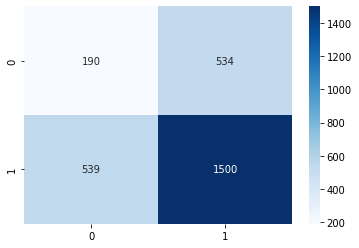

In [27]:
# Some predictions are continuous and thus not labeled as 1,0
predictions = np.where(resnet25_model.predict(test_data) > 0.5, 1, 0)
predictions

y_preds = flatten(predictions)

cm = confusion_matrix(test_labels, y_preds)
sns.heatmap(cm, annot = True, cmap='Blues', fmt='.4g')

In [28]:
target_names = ['Covid (Class 0)', 'Normal (Class 1)']
print(classification_report(test_labels, y_preds, target_names = target_names))

                  precision    recall  f1-score   support

 Covid (Class 0)       0.26      0.26      0.26       724
Normal (Class 1)       0.74      0.74      0.74      2039

        accuracy                           0.61      2763
       macro avg       0.50      0.50      0.50      2763
    weighted avg       0.61      0.61      0.61      2763



### Final Model

In [29]:
# Concatenate train and validation data
fulltrain = train_data.concatenate(validation_data)

In [30]:
# Fit the model on 80% data
final_model = resnet25_model.fit(fulltrain)

174/174 [==============================] - 26s 147ms/step - loss: 0.1094 - accuracy: 0.9890


In [31]:
filename = 'final_model.pkl'
pkl.dump(resnet25_model, open(filename, 'wb'))

INFO:tensorflow:Assets written to: ram://c59aa106-c312-4808-b630-ef664355ced3/assets


INFO:tensorflow:Assets written to: ram://c59aa106-c312-4808-b630-ef664355ced3/assets


In [32]:
# Save full model
resnet_model.save('fullmodel')

INFO:tensorflow:Assets written to: fullmodel\assets


INFO:tensorflow:Assets written to: fullmodel\assets


In [33]:
# Load model
new_model = tf.keras.models.load_model('fullmodel')
new_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 299, 299, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 299, 299, 3)      0         
                                                                 
 resnet50 (Functional)       (None, 10, 10, 2048)      23587712  
                                                                 
 flatten_2 (Flatten)         (None, 204800)            0         
                                                                 
 dense_3 (Dense)             (None, 256)               52429056  
                                                           

In [34]:
# Evaluate the restored model
loss, acc = new_model.evaluate(test_data, verbose=2)
print('Restored model, accuracy: {:5.2f}%'.format(100 * acc))

44/44 - 7s - loss: 0.1733 - accuracy: 0.9772 - 7s/epoch - 160ms/step
Restored model, accuracy: 97.72%
